Derived from Plot_Some_KDEs_18Aug2022

The major (initial) goal is to determine whether it is "trivial" to read 200 traack per event rather than 150 and see whether the model will process them correctly.  If so, the question to be answered is whether this will ameliorate the high costs observed for intervals with 150 tracks used and more apparently ignored.

In [1]:
!nvidia-smi

Fri Sep  8 16:05:40 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB           Off| 00000000:01:00.0 Off |                    0 |
| N/A   27C    P0               39W / 250W|   4616MiB / 40960MiB |     40%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

First, we grab matplotlib, and set the old "classic" style for some reason only Rui knows.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')

In [3]:
import numpy as np
import torch

These are the local imports. Make sure you import the correct model!

In [4]:
## from model.models import SimpleCNN4Layer_D35_sp as Model
##from model.models_mds_E import FourFeature_CNN6Layer_D as Model
from model.models_July2022_kde import TrackIntervalsToKDE_HalfDozen as Model
from model.models_July2022_kde_plus import TrackIntervalsToKDE_8Features as Model_8
##from model.collectdata import collect_data, collect_truth
## from model.collectdata_mdsA import collect_data, collect_truth

## to read in the tracks and KDE info by interval
##from model.collectdata_kde_Ellipsoids_aug2022_debug200tracks import collect_t2kde_data
##  collectdata_kde_Ellipsoids_MinBiasMagDown_14Nov should ignore "badEvents" and
##  use 250 tracks per interval
from model.collectdata_kde_Ellipsoids_MinBiasMagDown_14Nov import collect_t2kde_data
from model.training import select_gpu
from model.plots_mdsA import plot_ruiplot
from model.efficiency import pv_locations, efficiency
from model.core import modernize

## read in the canonical loss function used for tracks-to-kde algorithms
## and instantiate as for RunModel_IntervalTracks_to_KDE_18Aug2022_HalfDozen_iter3A-testing-10epochs-2em5_fullLHCbMC
from model.interval_kde_loss_Ba_postFacto import Loss
loss = Loss(epsilon=3e-6)

In [5]:
## this function takes an "absolute" interval number and converts it into an original event number and 
## interval within that event assuming there are 40 intervals in each event

def eventID(intervalNumber):
    eventNumber = int((intervalNumber)/40)
    localInterval = intervalNumber - eventNumber*40
    return eventNumber,localInterval

Select a GPU here. Same numbering as the NVidia-SMI tool.

In [6]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 NVIDIA A100-PCIE-40GB


Pick a file to load.

In [7]:
## mds validation = collect_data('dataAA/Oct03_20K_val.h5',
##validation = collect_t2kde_data('dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5',
## note -- MagDown was validation sample for Iter%A
validation = collect_t2kde_data('dataAA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5',
##validation = collect_t2kde_data('dataAA/1K_POCA_HLT1CPU_poca_kernel_evts_201022.h5',
                          batch_size=64,
                          pin_memory=True,
##                          slice=slice(None,100000),
                          shuffle=False,
##                          device=device,
                          )



Loading data...
  
kernel.shape =  (51314, 4000)
kernel.shape[0] =  51314
kernel.shape[1] =  4000
Y.shape =       (51314, 12000)
binsPerInterval =  100
nIntervals =        40
intervalKernels.shape =  (2052560, 100)


/data/home/sokoloff/.local/lib/python3.8/site-packages/awkward0/persist.py:509: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  schema = schema.tostring()


pocaMx.shape =  (51314,)
nEvts =  51314
pocaz.shape =  (51314,)
len(pocaMx[0]) =  119
len(pocaMx[1]) =  317
len(pocaMx[2]) =  260
len(pocaMx[3]) =  133
len(pocaMx[4]) =  196
 iEvt, nTrks =  0 119
 iEvt, nTrks =  1 317
 iEvt, nTrks =  2 260
 iEvt, nTrks =  3 133
 iEvt, nTrks =  4 196
 iEvt, nTrks =  5 109
 iEvt, nTrks =  6 211
 iEvt, nTrks =  7 179
 iEvt, nTrks =  8 258
 iEvt, nTrks =  9 324
 BAD ---- iEvt, iTrk =  123 154
 BAD ---- iEvt, iTrk =  2460 203
 BAD ---- iEvt, iTrk =  4484 129
 BAD ---- iEvt, iTrk =  4511 201
 BAD ---- iEvt, iTrk =  5575 132
 BAD ---- iEvt, iTrk =  8120 204
 BAD ---- iEvt, iTrk =  8747 364
 BAD ---- iEvt, iTrk =  9983 22
 BAD ---- iEvt, iTrk =  10651 235
 BAD ---- iEvt, iTrk =  11956 196
 BAD ---- iEvt, iTrk =  12010 77
 BAD ---- iEvt, iTrk =  13523 25
 BAD ---- iEvt, iTrk =  14817 315
 BAD ---- iEvt, iTrk =  15591 158
 BAD ---- iEvt, iTrk =  15592 71
 BAD ---- iEvt, iTrk =  16917 200
 BAD ---- iEvt, iTrk =  18541 35
 BAD ---- iEvt, iTrk =  21607 121
 BAD ---

import h5py
XY_file = 'dataAA/Oct03_20K_val.h5'

with h5py.File(XY_file, mode='r') as XY:
    xmax = np.asarray(XY['Xmax'])
    ymax = np.asarray(XY['Ymax'])

> Note: to get the real PV locations, use `collect_truth('file.h5', pvs=True)` to collect PVs (or SVs with `pvs=False`)

Let's just see how many NaNs we have in the dataset.

In [8]:
## print(*np.sum(np.isnan(validation.dataset.tensors[1].cpu().numpy()), 1))

PV = collect_truth('dataAA/Oct03_20K_val.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

PV.n.max().max()

PV.cat[0]

SV = collect_truth('dataAA/Oct03_20K_val.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])

Select a model to load. Make sure it matches the model you imported above.

> #### Mike note:
>
> If you use an old-style model, comment out the `d = modernize(d, 3)` line - that converts the old model key names to the new format.

In [9]:
#name = '/share/lazy/schreihf/PvFinder/models/Dec11_SimpleCNN4Layer_D35_sp_first200epochs_240K_lr_3em5_bs512_Alt_Loss_A_4p5_final.pyt'
##name = '/home/sokoloff/pv-finder/notebooks/Dec21_SimpleCNN4Layer_D35_sp_yetAnother200epochs_240K_lr_1em3_bs512_Alt_Loss_A_4p5/Dec21_SimpleCNN4Layer_D35_sp_yetAnother200epochs_240K_lr_1em3_bs512_Alt_Loss_A_4p5_final.pyt'
##name = '/home/sokoloff/pv-finder/notebooks/Dec21_SimpleCNN4Layer_D35_sp_yetAnother600epochs_240K_lr_3em4_bs512_Alt_Loss_A_4p5/Dec21_SimpleCNN4Layer_D35_sp_yetAnother600epochs_240K_lr_3em4_bs512_Alt_Loss_A_4p5_final.pyt'
##name = 'ML/Aug10_FourFeature_CNN6LayerPlus_TargetsA_First20epochs_160K_lr_1em3_bs64_Alt_Loss_A_3p0/Aug10_FourFeature_CNN6LayerPlus_TargetsA_First20epochs_160K_lr_1em3_bs64_Alt_Loss_A_3p0_final.pyt'
##name = 'ML/Aug11_FourFeature_CNN6LayerPlus_TargetsAA_First40epochs_fixedPert_160K_lr_1em3_bs64_Alt_Loss_A_3p0/Aug11_FourFeature_CNN6LayerPlus_TargetsAA_First40epochs_fixedPert__160K_lr_1em3_bs64_Alt_Loss_A_3p0_final.pyt'
##name = 'ML/Aug14_FourFeature_CNN6LayerPlus_TargetsAA_400epochs_160K_lr_3em4_bs64_Alt_Loss_A_3p0/Aug14_FourFeature_CNN6LayerPlus_TargetsAA_400epochs_160K_lr_3em4_bs64_Alt_Loss_A_3p0_399.pyt'
##name = 'ML/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5/Aug16_FourFeature_CNN6LayerPlus_TargetsAA_YetAnother100epochs_160K_lr_1em4_bs128_Alt_Loss_A_4p5_final.pyt'
original_weights = 'ML/26August_testing_HalfDozen_first_learning_iter5A_200epochs_2em5_fullLHCbMC_scrubbedData/26August_testing_HalfDozen_first_learning_iter5A_200epochs_2em5_fullLHCbMC_scrubbedData_final.pyt'
##  The 19July2023 weights are produced by pruning layers 2, 3, 4, 5 and 6 by 10% and retraining
pruned_weights   = 'ML/19July2023_testing_HalfDozen_first_learning_iter6A_10epochs_2em5_fullLHCbMC_scrubbedData/19July2023_testing_HalfDozen_first_learning_iter6A_10epochs_2em5_fullLHCbMC_scrubbedData_final.pyt'


nOut1 = 20
nOut2 = 20
nOut3 = 20
nOut4 = 20
nOut5 = 20

##model = Model(nOut1,nOut2,nOut3,nOut4,nOut5).to(device)
original_model = Model(nOut1,nOut2,nOut3,nOut4,nOut5)
pruned_model   = Model(nOut1,nOut2,nOut3,nOut4,nOut5)
##model_8        = Model_8(nOut1,nOut2,nOut3,nOut4,nOut5)

##model = Model().to(device)
d_original = torch.load(original_weights)
d_pruned   = torch.load(pruned_weights)
##d_8        = torch.
original_model.load_state_dict(d_original)
pruned_model.load_state_dict(d_pruned)
original_model.eval()
pruned_model.eval()

TrackIntervalsToKDE_HalfDozen(
  (layer1): Linear(in_features=9, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=20, bias=True)
  (layer6): Linear(in_features=20, out_features=100, bias=True)
)

Let's grab the outputs and labels as normal numpy arrays.

In [10]:
##%%time
with torch.no_grad():
    print("device = ",device)
    print("validation.dataset.tensors[0].shape = ",validation.dataset.tensors[0].shape)
    vdt0 = validation.dataset.tensors[0]
    vdt1 = validation.dataset.tensors[1]
    print("vdt0.shape = ",vdt0.shape)
    print("vdt1.shape = ",vdt1.shape)
    nSplit = []
    for ii in range(20):
        nSplit.append((ii+1)*100000)
        
    print("nSplit = ",nSplit)  
    
## torch.tensor_split creates a Python tuple, each of whose elements is a tensor
##    vdt0Split = torch.tensor_split(vdt0, 21)
##    vdt1Split = torch.tensor_split(vdt1, 21)
    
    vdt0Split = torch.tensor_split(vdt0,nSplit, dim=0)
    vdt1Split = torch.tensor_split(vdt1,nSplit, dim=0)

    print("len(vdt0Split) = ",len(vdt0Split))
    
    defaultSplitSize = vdt0Split[0].shape[0]
    print("defaultSpitSize = ",defaultSplitSize)

    ## use torch tensor.split https://pytorch.org/docs/stable/generated/torch.tensor_split.html

device =  cuda:0
validation.dataset.tensors[0].shape =  torch.Size([2051640, 9, 250])
vdt0.shape =  torch.Size([2051640, 9, 250])
vdt1.shape =  torch.Size([2051640, 100])
nSplit =  [100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1100000, 1200000, 1300000, 1400000, 1500000, 1600000, 1700000, 1800000, 1900000, 2000000]
len(vdt0Split) =  21
defaultSpitSize =  100000


In [11]:
## Let's look at the 1st 100 events 

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size


with torch.no_grad():
##   loop over the tensors stored in the vdtSplit tuple of tensors
##    for nTuple in range(len(vdtSplit)):
##    for iChunk in range(2):
##  for iChunk in range(len(vdt0Split)):
    for iChunk in range(1):

        original_outputs = original_model(vdt0Split[iChunk]).cpu().numpy()
        pruned_outputs   = pruned_model(vdt0Split[iChunk]).cpu().numpy()
        print("original_outputs.shape = ",original_outputs.shape)
        labels = vdt1Split[iChunk].cpu().numpy()
        print("label.shape = ",labels.shape)
        inputs = vdt0Split[iChunk].cpu().numpy()
        print("inputs.shape = ",inputs.shape)
        

original_outputs.shape =  (100000, 100)
label.shape =  (100000, 100)
inputs.shape =  (100000, 9, 250)


## 

In [12]:
##quit()

 event, interval, ymax =    0,    4,  0.50 


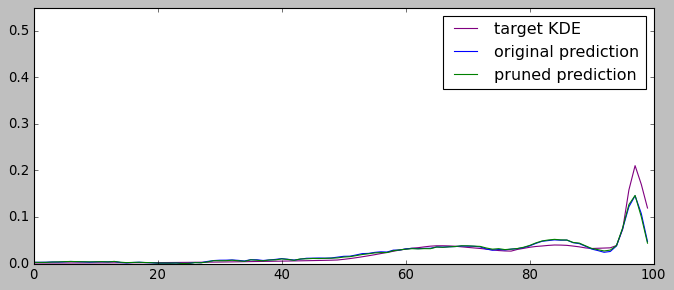

 event, interval, ymax =    0,   11,  0.63 


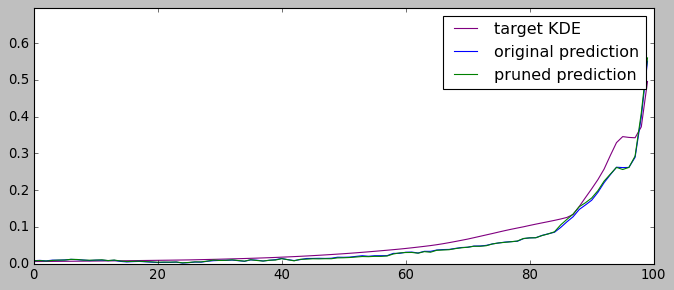

 event, interval, ymax =    0,   12,  0.70 


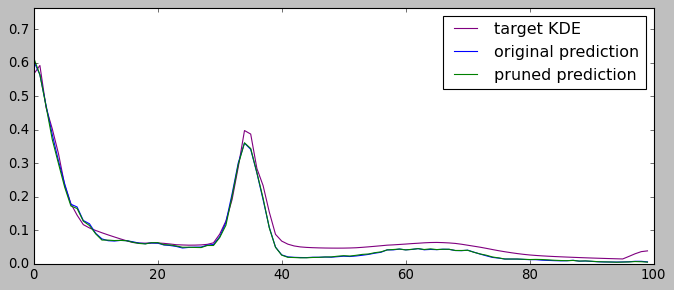

 event, interval, ymax =    0,   18,  0.50 


event =  0
   
    -------------------------------   
  
 event, interval, ymax =    1,   42,  0.95 


 event, interval, ymax =    1,   46,  1.13 


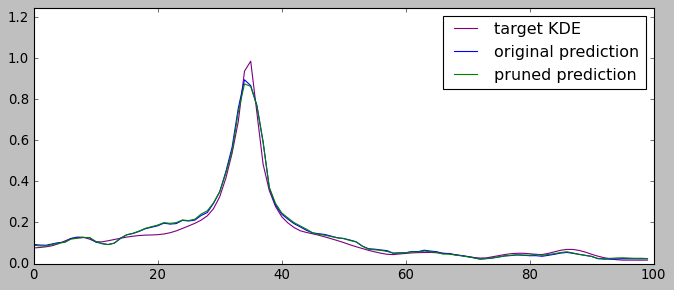

 event, interval, ymax =    1,   47,  0.50 


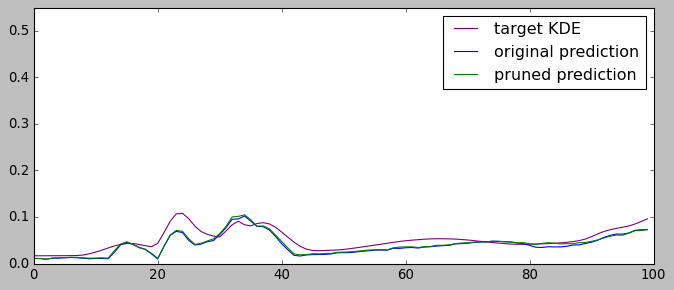

 event, interval, ymax =    1,   48,  0.66 


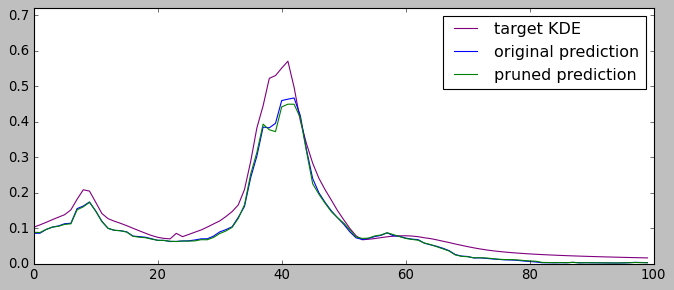

 event, interval, ymax =    1,   49,  0.50 


 event, interval, ymax =    1,   52,  0.50 


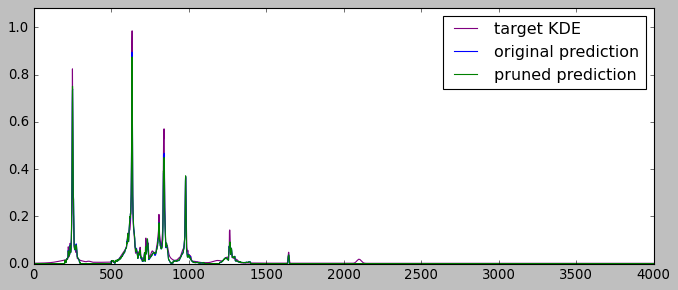

event =  1
   
    -------------------------------   
  
 event, interval, ymax =    2,   86,  0.50 


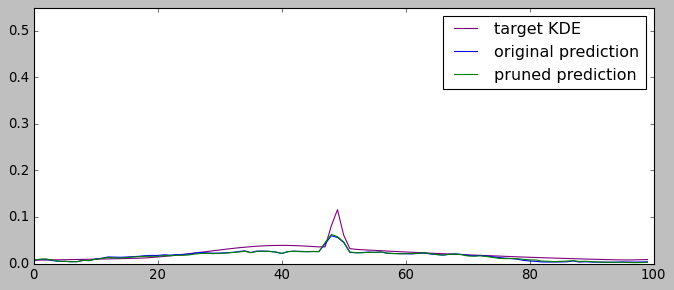

 event, interval, ymax =    2,   91,  0.50 


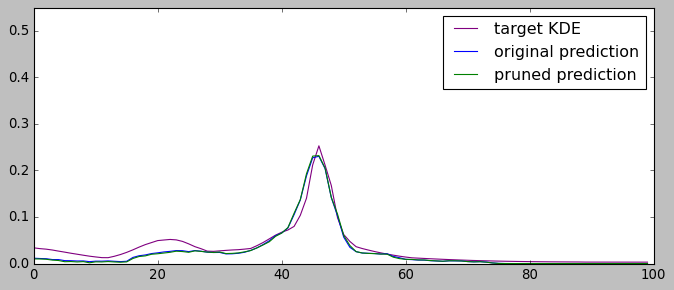

 event, interval, ymax =    2,   95,  0.50 


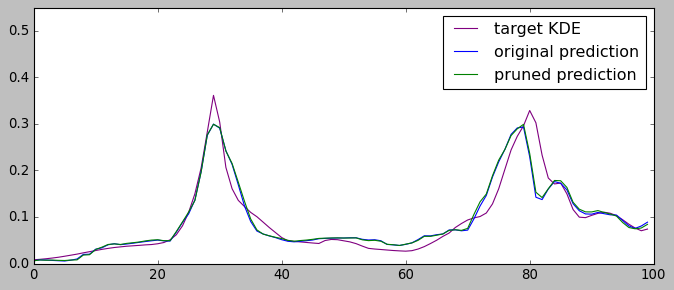

 event, interval, ymax =    2,   96,  0.50 


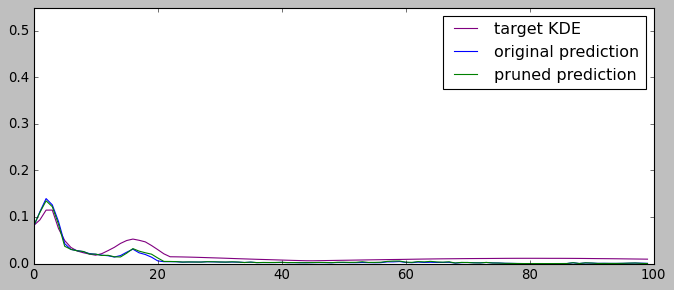

 event, interval, ymax =    2,  101,  0.99 


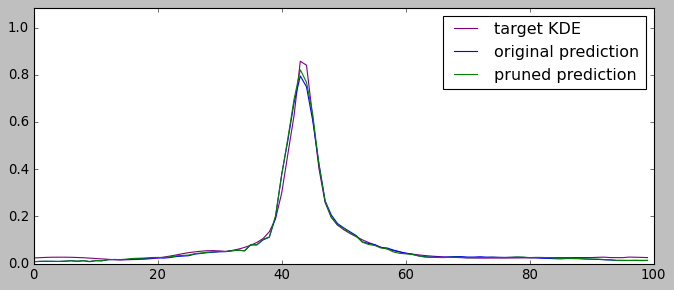

 event, interval, ymax =    2,  102,  2.60 


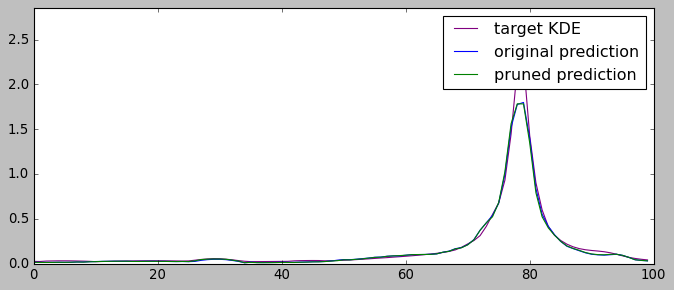

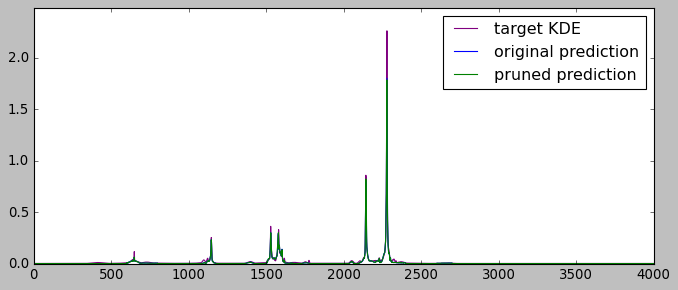

event =  2
   
    -------------------------------   
  
 event, interval, ymax =    3,  134,  1.22 


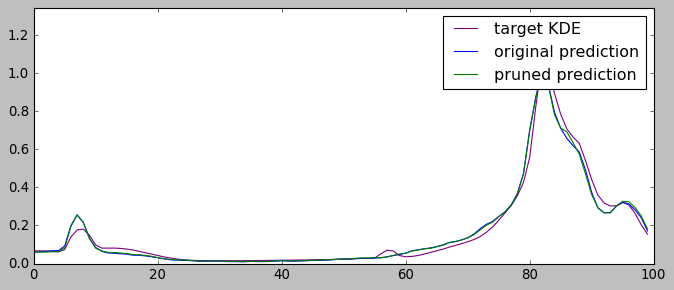

 event, interval, ymax =    3,  135,  0.50 


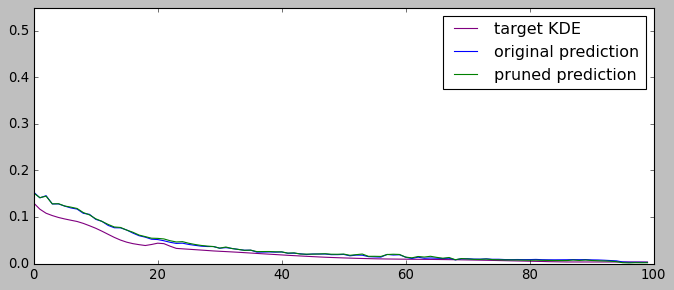

 event, interval, ymax =    3,  139,  0.50 


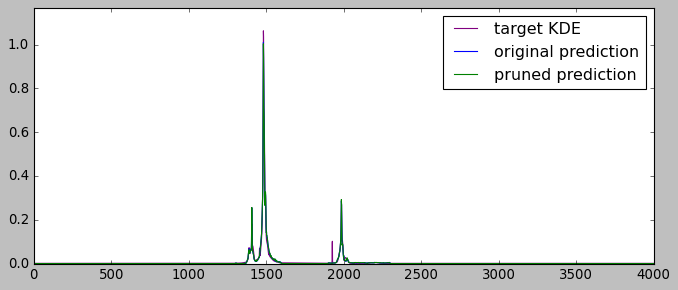

event =  3
   
    -------------------------------   
  
 event, interval, ymax =    4,  172,  1.25 


 event, interval, ymax =    4,  173,  0.50 


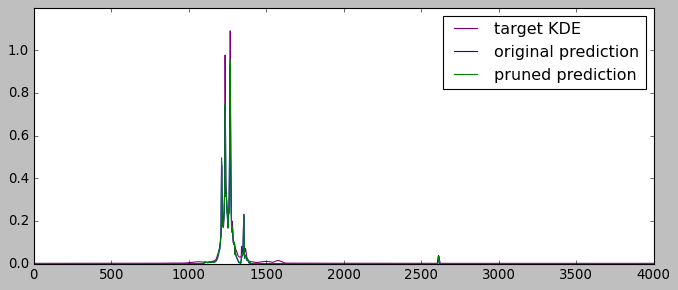

event =  4
   
    -------------------------------   
  
 event, interval, ymax =    5,  200,  0.50 


 event, interval, ymax =    5,  201,  0.50 


 event, interval, ymax =    5,  207,  0.50 


 event, interval, ymax =    5,  214,  0.50 


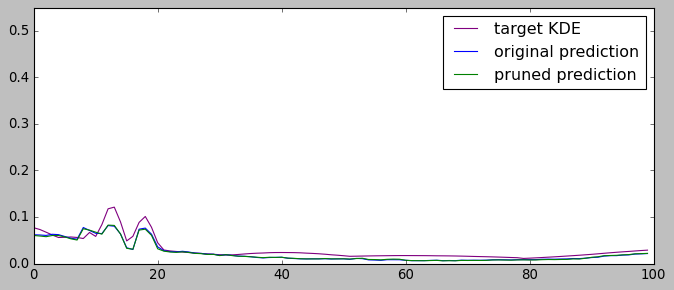

 event, interval, ymax =    5,  215,  0.82 


event =  5
   
    -------------------------------   
  
 event, interval, ymax =    6,  240,  0.50 


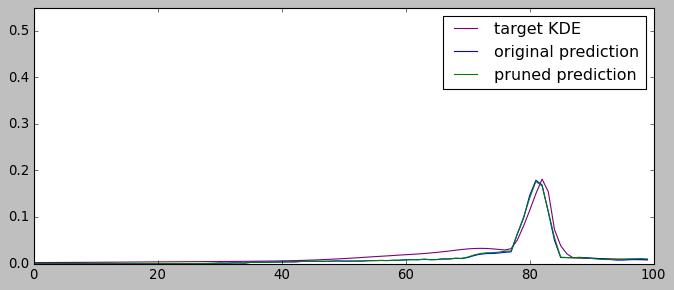

 event, interval, ymax =    6,  243,  0.50 


 event, interval, ymax =    6,  249,  1.61 


 event, interval, ymax =    6,  254,  0.50 


 event, interval, ymax =    6,  255,  0.59 


event =  6
   
    -------------------------------   
  
 event, interval, ymax =    7,  291,  1.41 


 event, interval, ymax =    7,  292,  0.50 


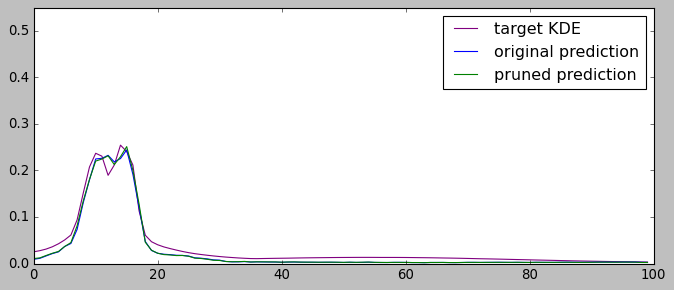

 event, interval, ymax =    7,  296,  0.50 


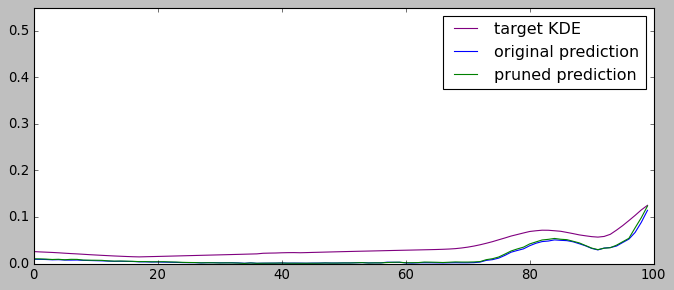

 event, interval, ymax =    7,  297,  1.64 


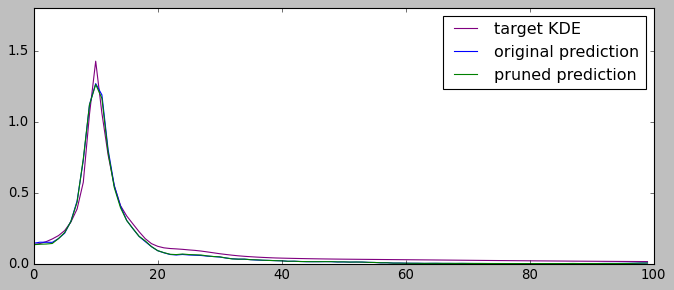

event =  7
   
    -------------------------------   
  
 event, interval, ymax =    8,  322,  0.83 


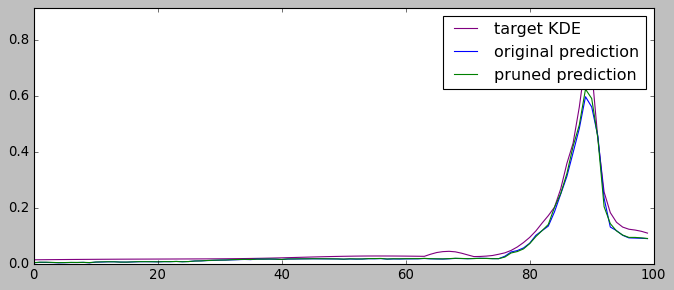

 event, interval, ymax =    8,  323,  0.50 


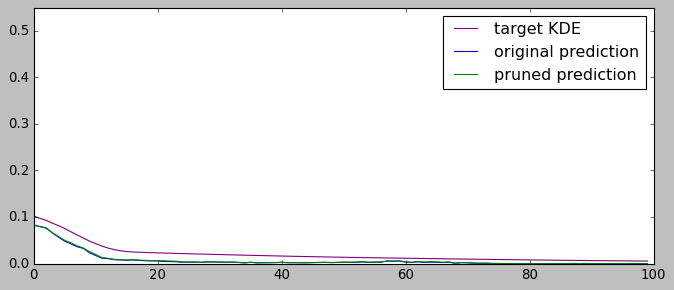

 event, interval, ymax =    8,  330,  0.98 


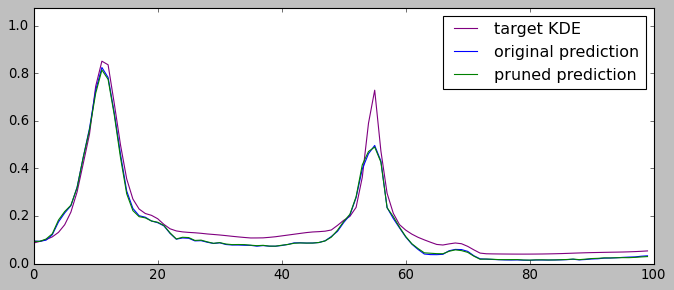

 event, interval, ymax =    8,  331,  1.69 


event =  8
   
    -------------------------------   
  
 event, interval, ymax =    9,  364,  0.53 


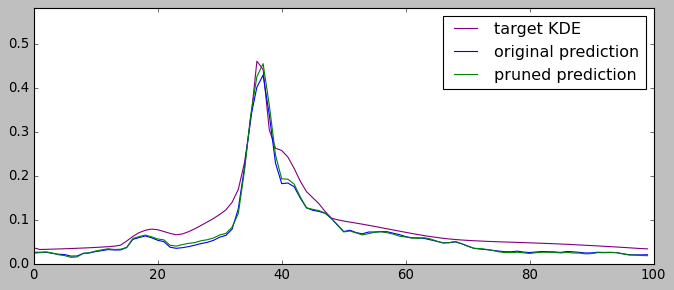

 event, interval, ymax =    9,  366,  0.84 


 event, interval, ymax =    9,  373,  0.50 


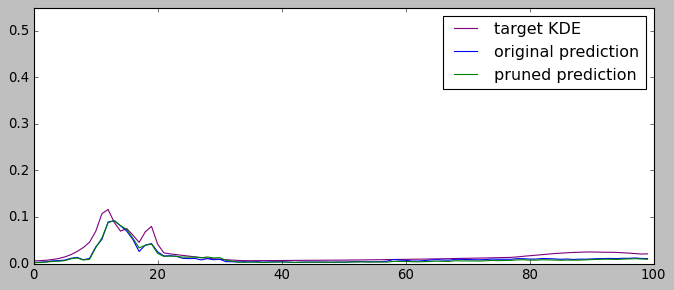

 event, interval, ymax =    9,  374,  0.63 


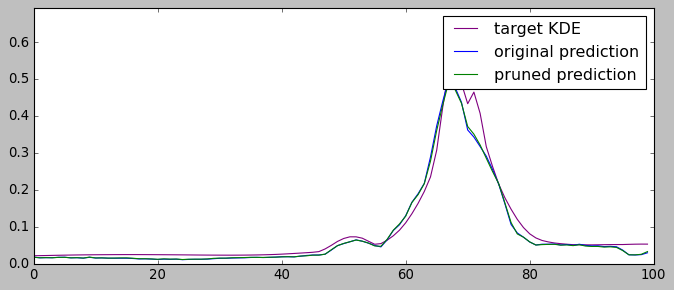

 event, interval, ymax =    9,  375,  2.05 


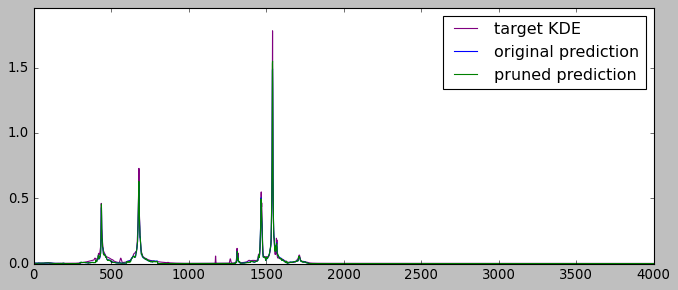

event =  9
   
    -------------------------------   
  


In [13]:
listOfEvents = np.arange(10)
for jj in listOfEvents:
    event_label  = np.asarray([])
    event_original_output = np.asarray([])
    event_pruned_output = np.asarray([])
##    print("inputs.shape = ",inputs.shape)
    event_chisq = 0.
    for interval in range(jj*40,jj*40+40):
        input = inputs[interval]
        label = np.asarray(labels[interval])
        original_output = np.asarray(original_outputs[interval])
        pruned_output   = np.asarray(pruned_outputs[interval])
        
        ymax = max(np.max(label),np.max(original_output))
        if (ymax>0.1):
            ymax = max(1.15*ymax,0.5)
            print(" event, interval, ymax = %4i, %4i, %5.2f " %(jj,interval,ymax))
            plt.figure()
            plt.plot(label, color='purple',label='target KDE')
            plt.plot(original_output,color='b', label='original prediction')
            plt.plot(pruned_output,color='green', label='pruned prediction')
            plt.legend()
            plt.ylim((0.,1.1*ymax))
            plt.show()
            
        event_label           = np.concatenate((event_label,label))
        event_original_output = np.concatenate((event_original_output,original_output))
        event_pruned_output   = np.concatenate((event_pruned_output,pruned_output))
    plt.figure()
    plt.plot(event_label,color='purple',label='target KDE')
    plt.plot(event_original_output,color='blue', label='original prediction')
    plt.plot(event_pruned_output,color='green', label='pruned prediction')
    plt.legend()
    label_max  = max(1.1*np.max(event_label),1.0)
    output_max = max(1.1*np.max(event_original_output),1.0)
    ymax = max(label_max,output_max)
    plt.ylim((0.,ymax))
    plt.show()
    print("event = ",jj)
    print('   ')
    print('    -------------------------------   ')
    print('  ')
        

In [14]:
##quit()
